<a href="https://colab.research.google.com/github/thanktua-spp/machine-learning-fundamentals/blob/main/MNIST_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [ ]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.npz')

## Import data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print(f'X Train shape = {x_train.shape}')
print(f'y Train shape = {y_train.shape}')

print(f'X Test shape = {x_test.shape}')
print(f'y Test shape = {y_test.shape}')

X Train shape = (60000, 28, 28)
y Train shape = (60000,)
X Test shape = (10000, 28, 28)
y Test shape = (10000,)


In [ ]:
type(x_train[0])

numpy.ndarray

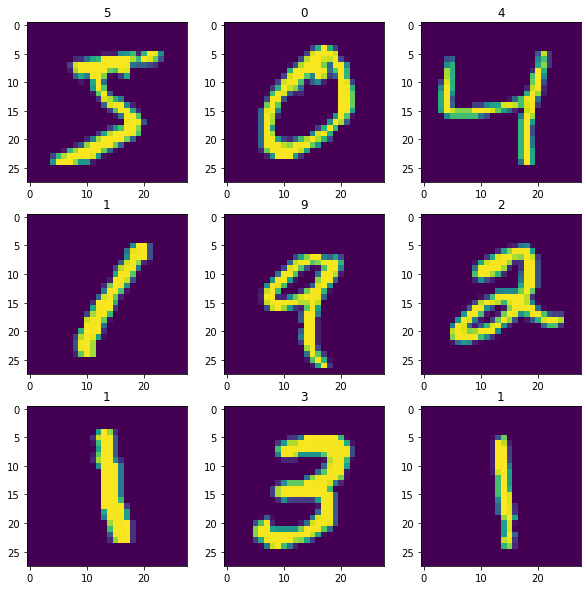

In [ ]:
from IPython.core.pylabtools import figsize
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_train[i])
  plt.title(y_train[i])
plt.show()

In [ ]:
y_train[:9]

array([5, 0, 4, 1, 9, 2, 1, 3, 1], dtype=uint8)

In [ ]:
y_train[:9][y_train[:9] < 2]

array([0, 1, 1, 1], dtype=uint8)

In [ ]:
y_bin_train = y_train[y_train < 2]
y_bin_train

array([0, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [ ]:
x_bin_train = x_train[np.where(y_train < 2)]

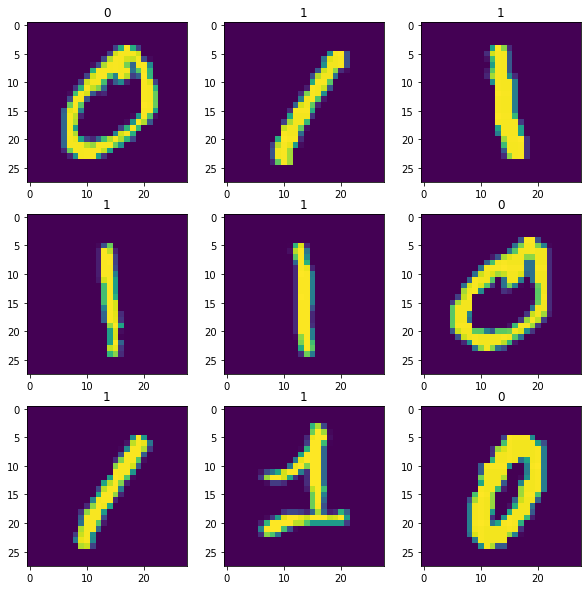

In [ ]:
from IPython.core.pylabtools import figsize
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(x_bin_train[i])
  plt.title(y_bin_train[i])
plt.show()

In [ ]:
print(f'X Train shape = {x_bin_train.shape}')
print(f'y Train shape = {y_bin_train.shape}')

# print(f'X Test shape = {x_test.shape}')
# print(f'y Test shape = {y_test.shape}')

X Train shape = (12665, 28, 28)
y Train shape = (12665,)


In [ ]:
import seaborn as sns

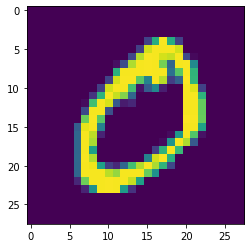

In [ ]:
plt.imshow(x_bin_train[0])

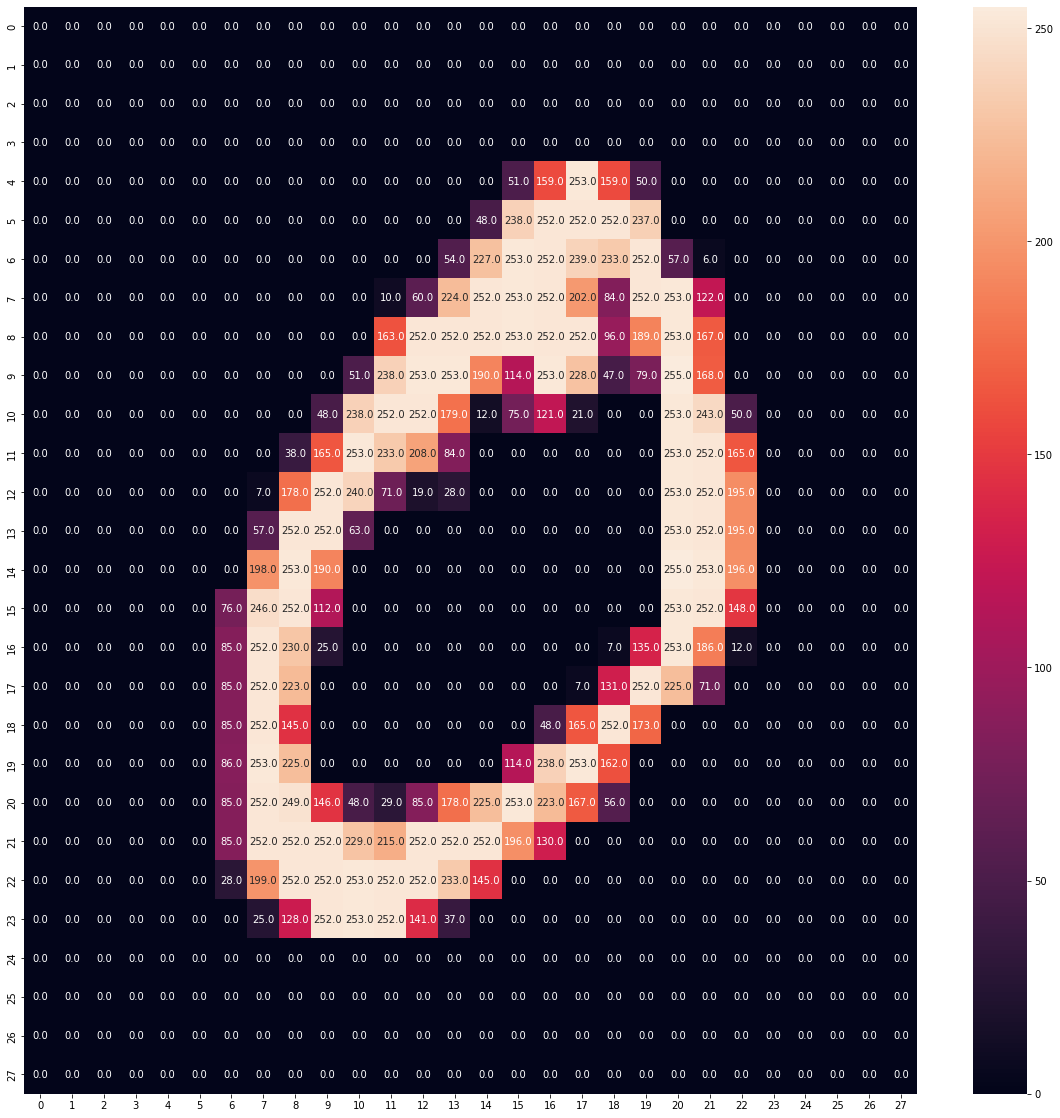

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(x_bin_train[0], annot=True, fmt='.1f')

## Data Transformation (Pre-processing)

- Normalization: Transforms each individual feature within the range of zero and o